In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.base_env import ActionTuple

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda NVIDIA GeForce RTX 3060


### Training parameters (global variables in Captical letters)

In [3]:
N_STATES  = 243
N_ACTIONS = 39

N_AGENTS = 3   #My Unity scene has three training environment

HIDDEN_UNITS = 512

BATCH_SIZE = 2048  
BUFFER_SIZE = 20480
LEARNING_RATE = 0.0003
BETA = 0.005
EPSILON = 0.2
LAMBD = 0.95
N_EPOCH = 3

GAMMA = 0.995

MAX_STEPS = 3000 #Walker.yaml 30M
TIME_HORIZON = 1000 

In [4]:
ENV = BEHAVIOR_NAME = NET = None

In [5]:
# tensor arrays to store (s,a,r,s1) data collected from N_AGENTS in TIME_HORIZON steps
a = torch.FloatTensor([[0]]*N_AGENTS ) #create NoAgents by 1 tensor
b = torch.FloatTensor([[0]*N_ACTIONS ]*N_AGENTS ) 
c = torch.FloatTensor([[0]*N_STATES  ]*N_AGENTS ) 

VALUES =REWARDS = MASKS = [a]*TIME_HORIZON
LOG_PROBS = ACTIONS = [b]*TIME_HORIZON
STATES = NEXT_STATES = [c]*TIME_HORIZON

### Actor, critic, forward prediction NN

In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)

In [7]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(N_STATES, HIDDEN_UNITS),
            nn.LayerNorm(HIDDEN_UNITS),
            nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS),
            nn.LayerNorm(HIDDEN_UNITS),
            nn.Linear(HIDDEN_UNITS, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(N_STATES, HIDDEN_UNITS),
            nn.LayerNorm(HIDDEN_UNITS),
            nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS),
            nn.LayerNorm(HIDDEN_UNITS),
            nn.Linear(HIDDEN_UNITS, N_ACTIONS)
        )
        
        self.fNET = nn.Sequential(
            nn.Linear(N_STATES, HIDDEN_UNITS),
            nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS),
            nn.Linear(HIDDEN_UNITS, N_STATES)
        )
        
        self.log_std = nn.Parameter(torch.ones(1, N_ACTIONS) * 0.0)
        self.apply(init_weights)
    
    def forward(self, x):
        pred_next_state = self.fNET(x)
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value, pred_next_state

In [8]:
NET = Net().to(device)

In [9]:
OPTIMIZER = optim.Adam(NET.parameters(), lr=LEARNING_RATE )

### function to interacts with Unity NoSteps

In [19]:
def Interact_with_Unity_one_step (DecisionSteps):
    # ENV and NET are global variables        
    s = DecisionSteps.obs[0]  
    s = torch.FloatTensor(s)       
    dist, value, _ = NET(s.to(device))
    a = dist.sample() 
    log_prob = dist.log_prob(a)
    
    a = a.cpu().detach().numpy()
    a = ActionTuple(np.array(a, dtype=np.float32))
    ENV.set_actions(BEHAVIOR_NAME, a)   
    ENV.step()
    a = a._continuous #convert from ActionTuple to np.array
    a = torch.FloatTensor(a) # convert from np.array to Tensor
    return s, value, a, log_prob

In [11]:
def Collect_REWARDS_and_MASKS (step, AgentSteps, flag): 
    #flag=1:decision, 0: terminal steps
    #REWARDS, MASKS, NEXT_STATES are gloable variables
    r = AgentSteps.reward
    r = torch.FloatTensor(r).unsqueeze(1)
    s = torch.FloatTensor(AgentSteps.obs[0])
    s = torch.FloatTensor(s).to(device) 
    for idx in range(len(AgentSteps)):
        AgentID = AgentSteps.agent_id[idx]
        REWARDS[step][AgentID]=r[idx]
        MASKS[step][AgentID]= flag
        NEXT_STATES[step][AgentID]=s[idx]

In [12]:
def collect_training_data ():
    #ENV, BEHAVIOR_NAME are gloabl variables
    #states, ACTIONS, LOG_PROBS, VALUES, REWARDS, MASKS, NEXT_STATES are global variables (tensor array)
    step = 0  
    DecisionSteps, TerminalSteps = ENV.get_steps(BEHAVIOR_NAME)
    while(step < TIME_HORIZON): #try to run NoSteps good steps
        #if we have no decision agents,then continue next loop without increase step
        if(len(DecisionSteps) == 0): 
            ENV.reset() 
            DecisionSteps, TerminalSteps = ENV.get_steps(BEHAVIOR_NAME)
            continue #continue next while loop without increase step
        
        # Interacts with Unity one step
        s, value, a, log_prob = Interact_with_Unity_one_step (DecisionSteps)
        NextDecisionSteps, NextTerminalSteps = ENV.get_steps(BEHAVIOR_NAME)

        #if this or next decision step misses some agents, then do not collect data
        if(len(DecisionSteps)!= N_AGENTS or len(NextDecisionSteps)!= N_AGENTS): 
            DecisionSteps, TerminalSteps = NextDecisionSteps, NextTerminalSteps
            continue      #continue next while loop without increase step
        
        #else this and next decision steps includes all agents, collect (s, a, r, s1)
        for idx in range(len(DecisionSteps)):
            #find decision agents and record their state, value and ACTIONS
            AgentID = DecisionSteps.agent_id[idx]
            STATES[step][AgentID]=s[idx]
            VALUES[step][AgentID]=value[idx]
            ACTIONS[step][AgentID]=a[idx]
            LOG_PROBS[step][AgentID]=log_prob[idx]

        #collect reward of this action from next decision and terminal steps
        if(len(NextTerminalSteps) >0):
            #if next step has terminal agents, then collect terminal agents first
            Collect_REWARDS_and_MASKS(step, NextTerminalSteps, 0)
        else:  #else collect r and next state from decision steps
            Collect_REWARDS_and_MASKS(step, NextDecisionSteps, 1)
        
        step = step + 1 #increase step and run next while
        DecisionSteps, TerminalSteps = NextDecisionSteps, NextTerminalSteps

### GAE

In [13]:
def compute_gae(next_value):
    value1 = VALUES + [next_value.cpu()]
    gae = 0
    returns = []
    for step in reversed(range(TIME_HORIZON )):
        delta = REWARDS[step] + GAMMA*value1[step + 1]*MASKS[step]-value1[step]
        gae = delta + GAMMA*LAMBD*MASKS[step]*gae
        returns.insert(0, gae + VALUES[step])
    return returns

### PPO optimization

In [14]:
def ppo_iter():
    buffer_size = MERGED_STATES.size(0)
    for _ in range(buffer_size// BATCH_SIZE ):
        rand_ids = np.random.randint(0, buffer_size, BATCH_SIZE )
        yield MERGED_STATES[rand_ids, :], MERGED_ACTIONS[rand_ids, :], MERGED_NEXT_STATES[rand_ids, :],\
              MERGED_LOG_PROBS[rand_ids, :], MERGED_RETURNS[rand_ids, :], MERGED_ADVANTAGES[rand_ids, :]

In [27]:
def ppo_update():
    print("epoch:")
    for epoch in range(N_EPOCH):
        print(epoch, end = ", ")
        for b_s, b_a, b_s_, b_old_LOG_PROBS, b_return, b_advantage in ppo_iter():
            dist, value, pred_b_s_ = NET(b_s.to(device))       
            critic_loss = (b_return.to(device) - value).pow(2).mean()
            entropy = dist.entropy().mean()
            b_a_new = dist.sample()
            b_new_LOG_PROBS = dist.log_prob(b_a_new)
            ratio = (b_new_LOG_PROBS - b_old_LOG_PROBS.to(device)).exp()
            surr1 = ratio * b_advantage.to(device)
            surr2 = torch.clamp(ratio, 1.0-EPSILON, 1.0+EPSILON) * b_advantage.to(device)
            actor_loss  = - torch.min(surr1, surr2).mean()
            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy
            OPTIMIZER.zero_grad()
            loss.backward()
            OPTIMIZER.step()
    return float(critic_loss), float(actor_loss)

### Try one training iteration

In [16]:
ENV = UnityEnvironment(file_name= None, base_port=5004)

In [17]:
ENV.reset()
behavior_names = list(ENV.behavior_specs.keys())
BEHAVIOR_NAME = behavior_names[0]
print(BEHAVIOR_NAME)

Walker?team=0


In [20]:
collect_training_data()
print(len(LOG_PROBS), LOG_PROBS[0].shape)
print(len(VALUES), VALUES[0].shape)
print(len(REWARDS), REWARDS[0].shape)
print(len(MASKS), MASKS[0].shape)
print(len(STATES), STATES[0].shape)
print(len(ACTIONS), ACTIONS[0].shape)
print(len(NEXT_STATES), NEXT_STATES[0].shape)

1000 torch.Size([3, 39])
1000 torch.Size([3, 1])
1000 torch.Size([3, 1])
1000 torch.Size([3, 1])
1000 torch.Size([3, 243])
1000 torch.Size([3, 39])
1000 torch.Size([3, 243])


In [21]:
# send last next state to calculate value
_, next_value, _ = NET(NEXT_STATES[-1].to(device)) 

In [22]:
RETURNS = compute_gae(next_value)

In [23]:
MERGED_RETURNS   = torch.cat(RETURNS).detach()
MERGED_LOG_PROBS = torch.cat(LOG_PROBS).detach()
MERGED_VALUES    = torch.cat(VALUES).detach()
MERGED_STATES    = torch.cat(STATES) 
MERGED_NEXT_STATES   = torch.cat(NEXT_STATES) 
MERGED_ACTIONS   = torch.cat(ACTIONS)
MERGED_ADVANTAGES = MERGED_RETURNS - MERGED_VALUES

In [24]:
print(len(MERGED_RETURNS), MERGED_RETURNS[0].shape)
print(len(MERGED_LOG_PROBS), MERGED_LOG_PROBS[0].shape)
print(len(MERGED_VALUES), MERGED_VALUES[0].shape)
print(len(MERGED_STATES), MERGED_STATES[0].shape)
print(len(MERGED_NEXT_STATES), MERGED_NEXT_STATES[0].shape)
print(len(MERGED_ACTIONS), MERGED_ACTIONS[0].shape)
print(len(MERGED_ADVANTAGES), MERGED_ADVANTAGES[0].shape)

3000 torch.Size([1])
3000 torch.Size([39])
3000 torch.Size([1])
3000 torch.Size([243])
3000 torch.Size([243])
3000 torch.Size([39])
3000 torch.Size([1])


In [28]:
critic_loss, actor_loss = ppo_update()
print(critic_loss, actor_loss)

epoch:
0, 1, 2, 56.777252197265625 -15.788347244262695


In [29]:
ENV.close()

# Interact with Unity for N steps

In [30]:
ENV = UnityEnvironment(file_name= None, base_port=5004)

In [31]:
ENV.reset()
BEHAVIOR_NAME = list(ENV.behavior_specs.keys())
BEHAVIOR_NAME = BEHAVIOR_NAME[0]

In [34]:
ActorLossLst = []
CriticLossLst = []
ForwardLossLst = []
frame_idx  = 0 

while (frame_idx < MAX_STEPS):
    print("\nframe idx = ", frame_idx)
    print("Interacts with Unity to collect training data")
    collect_training_data()
    _, next_value, _ = NET(NEXT_STATES[-1].to(device)) 
    
    print("Compute GAE of these training data set")
    RETURNS = compute_gae(next_value)
    MERGED_RETURNS   = torch.cat(RETURNS).detach()
    MERGED_LOG_PROBS = torch.cat(LOG_PROBS).detach()
    MERGED_VALUES    = torch.cat(VALUES).detach()
    MERGED_STATES    = torch.cat(STATES) 
    MERGED_NEXT_STATES    = torch.cat(NEXT_STATES) 
    MERGED_ACTIONS   = torch.cat(ACTIONS)
    MERGED_ADVANTAGES = MERGED_RETURNS - MERGED_VALUES
    
    print("Optimize NN with PPO and curiosity")
    critic_loss, actor_loss = ppo_update()
    CriticLossLst.append(critic_loss)
    ActorLossLst.append(actor_loss)

    frame_idx += TIME_HORIZON


frame idx =  0
Interacts with Unity to collect training data
Compute GAE of these training data set
Optimize NN with PPO and curiosity
epoch:
0, 1, 2, 
frame idx =  1000
Interacts with Unity to collect training data
Compute GAE of these training data set
Optimize NN with PPO and curiosity
epoch:
0, 1, 2, 
frame idx =  2000
Interacts with Unity to collect training data
Compute GAE of these training data set
Optimize NN with PPO and curiosity
epoch:
0, 1, 2, 

In [35]:
ENV.close()

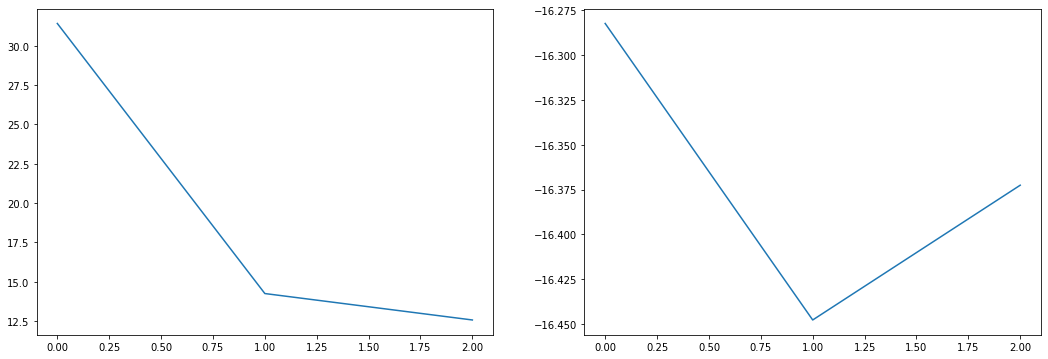

In [36]:
fig=plt.figure(figsize=(18, 6))
fig.add_subplot(1, 2, 1)  # 1 row, 2 columns
plt.plot(CriticLossLst)

fig.add_subplot(1, 2, 2) 
plt.plot(ActorLossLst)

plt.show()